# Suitability Analysis: Best place within the Boston Region for a Tufts UEP student and BU Law student to live without a car 
UEP-239 Final Project\
By: Justina Cheng

[DESCRIPTION]

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim
from pyproj import CRS
from shapely.geometry import LineString, Point, Polygon, box

import rasterio
from rasterio.plot import show
from rasterio import features

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

## View base map

In [12]:
outline_25k = gpd.read_file("./data/outline25k/OUTLINE25K_POLY.shp")
outline_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AREA_ACRES  918 non-null    float64 
 1   OBJECTID    918 non-null    int64   
 2   SHAPE_AREA  918 non-null    float64 
 3   SHAPE_LEN   918 non-null    float64 
 4   geometry    918 non-null    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 36.0 KB


epsg:26986


<AxesSubplot:>

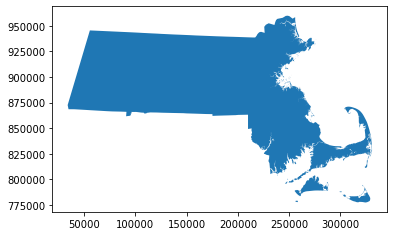

In [13]:
print(outline_25k.crs)
outline_25k.plot()

In [14]:
ma_zcta = gpd.read_file("./data/tl_2010_25_zcta500/tl_2010_25_zcta500.shp")
ma_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 47.1+ KB


epsg:4269


<AxesSubplot:>

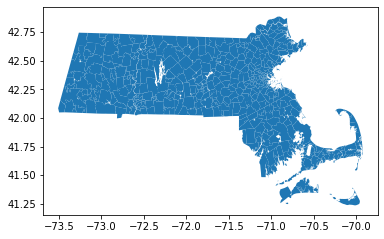

In [15]:
print(ma_zcta.crs)
ma_zcta.plot()

In [16]:
outline_25k = outline_25k.to_crs('epsg:6491')
ma_zcta = ma_zcta.to_crs('epsg:6491')
outline_25k.crs == ma_zcta.crs

True

In [17]:
ma_zcta_25k = gpd.clip(ma_zcta, outline_25k)
ma_zcta_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 50.9+ KB


<AxesSubplot:>

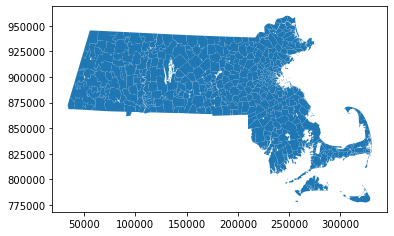

In [18]:
ma_zcta_25k.plot()

In [20]:
mpo = gpd.read_file("./data/MPO_Boundaries/MPO_Boundaries.shp")
mpo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    13 non-null     int64   
 1   MPO         13 non-null     object  
 2   created_us  0 non-null      object  
 3   created_da  13 non-null     object  
 4   last_edite  2 non-null      object  
 5   last_edi_1  13 non-null     object  
 6   GlobalID    13 non-null     object  
 7   ShapeSTAre  13 non-null     float64 
 8   ShapeSTLen  13 non-null     float64 
 9   geometry    13 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(6)
memory usage: 1.1+ KB


In [21]:
mpo

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,2,Berkshire,None,1970-01-01,None,1970-01-01,{08FDA544-18B0-412A-B442-287E53E987F7},2.451015e+09,2.471530e+05,"POLYGON ((-8128884.676 5272654.345, -8128962.2..."
1,3,Cape Cod,None,1970-01-01,None,1970-01-01,{B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01},1.067067e+09,1.288227e+06,"MULTIPOLYGON (((-7813968.781 5173329.197, -781..."
2,4,Central Massachusetts,None,1970-01-01,None,1970-01-01,{CC777E14-53C8-42AD-B421-71444DA0BB60},2.487546e+09,2.683265e+05,"POLYGON ((-7977225.352 5223837.273, -7973861.8..."
3,5,Franklin,None,1970-01-01,None,1970-01-01,{4804E708-6B89-4A85-9383-BD91F7589981},1.876456e+09,2.527017e+05,"POLYGON ((-8046511.241 5269691.856, -8045276.8..."
4,6,Montachusett,None,1970-01-01,None,1970-01-01,{F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528},1.772355e+09,2.748684e+05,"POLYGON ((-7976246.504 5267152.001, -7976121.9..."
5,7,Martha's Vineyard,None,1970-01-01,None,1970-01-01,{84077DC9-D5D1-471D-9A64-1E5748F80B92},2.757449e+08,3.701721e+05,"MULTIPOLYGON (((-7859473.886 5083806.270, -785..."
6,8,Merrimack Valley,None,1970-01-01,None,1970-01-01,{C09CD5BA-4FE1-45DD-838E-19F2ECF618DB},7.188680e+08,3.847121e+05,"MULTIPOLYGON (((-7890949.271 5294156.354, -788..."
7,9,Northern Middlesex,None,1970-01-01,None,1970-01-01,{5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD},5.073539e+08,1.410283e+05,"POLYGON ((-7922038.111 5250986.670, -7923186.5..."
8,10,Nantucket,None,1970-01-01,None,1970-01-01,{633A0B7F-266B-4F07-AA30-EC320231ADAA},1.266795e+08,1.680333e+05,"MULTIPOLYGON (((-7797087.819 5069759.518, -779..."
9,11,Pioneer Valley,None,1970-01-01,None,1970-01-01,{B01F3417-DC74-4561-AE49-935ACC6EF1FF},3.054352e+09,3.206858e+05,"POLYGON ((-8049986.018 5212603.033, -8049953.4..."


<AxesSubplot:>

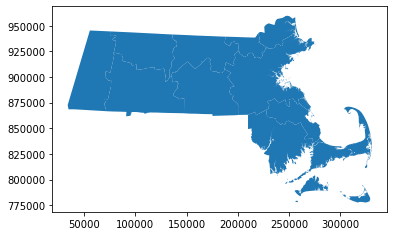

In [27]:
mpo = mpo.to_crs('epsg:6491')
mpo.plot()


In [28]:
boston_region = mpo.loc[mpo.MPO == 'Boston Region']
boston_region

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
10,12,Boston Region,None,1970-01-01,DINOCCOD,2018-04-18,{3801574E-3CF1-4344-BE7C-8B2FBA431DD8},3.524379e+09,1.665026e+06,"MULTIPOLYGON (((261954.246 925125.468, 261961...."


In [44]:
boston_zcta = ma_zcta_25k[ma_zcta_25k.centroid.within(boston_region.geometry[10])].reset_index()
boston_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       159 non-null    int64   
 1   STATEFP00   159 non-null    object  
 2   ZCTA5CE00   159 non-null    object  
 3   GEOID00     159 non-null    object  
 4   CLASSFP00   159 non-null    object  
 5   MTFCC00     159 non-null    object  
 6   FUNCSTAT00  159 non-null    object  
 7   ALAND00     159 non-null    int64   
 8   AWATER00    159 non-null    int64   
 9   INTPTLAT00  159 non-null    object  
 10  INTPTLON00  159 non-null    object  
 11  PARTFLG00   159 non-null    object  
 12  geometry    159 non-null    geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 16.3+ KB


In [45]:
boston_zcta

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482...."
1,32,25,01867,2501867,B5,G6350,S,25857991,46300,+42.5351829,-071.1054234,N,"POLYGON ((234193.323 919471.462, 234167.381 91..."
2,33,25,01880,2501880,B5,G6350,S,18969895,1554312,+42.5043600,-071.0640609,N,"POLYGON ((233593.527 918646.107, 233786.679 91..."
3,34,25,01730,2501730,B5,G6350,S,34703585,424511,+42.4993313,-071.2819054,N,"POLYGON ((215991.167 913794.709, 215916.137 91..."
4,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,489,25,02030,2502030,B5,G6350,S,39440450,832120,+42.2341291,-071.2834628,N,"POLYGON ((215268.989 884982.344, 215020.550 88..."
155,490,25,02052,2502052,B5,G6350,S,37335006,608718,+42.1845991,-071.3053065,N,"POLYGON ((214616.455 880362.751, 214622.559 88..."
156,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90..."
157,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89..."


<AxesSubplot:>

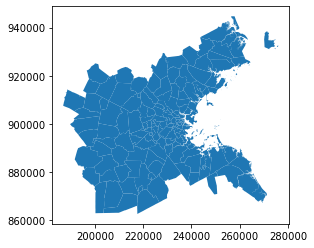

In [46]:
boston_zcta.plot()

## Distance to Necessities/Amenities
Amenities are defined as food/groceries, healthcare institutions (acute care, urgent care, hospitals, etc.), safety (firestations)